In [1]:
import tensorflow as tf
import tensorflow_io as tfio
import matplotlib.pyplot as plt
import numpy as np
from numpy import genfromtxt
import pickle
import os

In [2]:
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [3]:
def get_label_vector(times, onset_times, fuzzy=False):
    a = np.reshape(onset_times, (-1,1))
    b = np.reshape(times, (1,-1))
    onset_onehot = np.sum(np.abs(a - b) < HOP/(2*sr), 0)
    onset_wide = np.sum(np.abs(a - b) < 3*HOP/(2*sr), 0)
    onset_fuzzy = 0.25*onset_wide + 0.25*onset_onehot
    
    if fuzzy: 
        return onset_fuzzy
    else:
        return onset_onehot

In [4]:
frame_dir = 'datasets/initslurtest_vn/frames/'
label_dir = 'datasets/initslurtest_vn/initslurtest_vn_annotations/'
audio_dir = 'datasets/initslurtest_vn/initslurtest_vn_wav/'
HOP = 440
sr = 44100
N_MARGIN = 7 # How many frames to include before and after focus frame
clips_spects = []
clips_onsets = []
for n in range(1,20):
    if n==17:
        continue
        # TODO: solve the 17 case
    print(n)
    
    frame_name = frame_dir + "slurtest{:02d}".format(n) + ".pickle"
    label_name = label_dir+"{:02d}".format(n)+".txt"
    audio_name  = audio_dir + "slurtest{:02d}".format(n) + ".wav"
    
    # Get audio
    audio = tfio.audio.AudioIOTensor(audio_name)
    length = len(audio)/sr
    
    # Get label vector
    with open(frame_name, 'rb') as handle:
        new_spect = np.array(pickle.load(handle))
        print(new_spect.shape)
    times = np.arange(0, length, HOP/sr)
    print("Audio clip defined from {:.3f} s to {:.3f} s".format(0, length))
    print("With a feature frequency of {:.3f} s this yields {} features".format(HOP/sr, len(times)))
    onset_times = genfromtxt(label_name, delimiter=',')
    print("Onsets start at {} and end at {}".format(onset_times[0], onset_times[-1]))
    labels = get_label_vector(times, onset_times, fuzzy=False)[N_MARGIN:-N_MARGIN-1]
    print(labels.shape)
    print()
    clips_spects.append(new_spect)
    clips_onsets.append(labels)

1
(1686, 80, 15, 3)
Audio clip defined from 0.000 s to 16.962 s
With a feature frequency of 0.010 s this yields 1701 features
Onsets start at 0.767 and end at 15.158
(1686,)

2
(1609, 80, 15, 3)
Audio clip defined from 0.000 s to 16.196 s
With a feature frequency of 0.010 s this yields 1624 features
Onsets start at 0.598 and end at 14.528
(1609,)

3
(1646, 80, 15, 3)
Audio clip defined from 0.000 s to 16.567 s
With a feature frequency of 0.010 s this yields 1661 features
Onsets start at 0.838 and end at 14.697
(1646,)

4
(1585, 80, 15, 3)
Audio clip defined from 0.000 s to 15.961 s
With a feature frequency of 0.010 s this yields 1600 features
Onsets start at 0.458 and end at 14.867
(1585,)

5
(3403, 80, 15, 3)
Audio clip defined from 0.000 s to 34.099 s
With a feature frequency of 0.010 s this yields 3418 features
Onsets start at 0.488 and end at 31.757
(3403,)

6
(4959, 80, 15, 3)
Audio clip defined from 0.000 s to 49.621 s
With a feature frequency of 0.010 s this yields 4974 features

In [5]:
n_folds = 6
clips_per_fold = 3

_, y_dim, x_dim, n_channels = clips_spects[0].shape

# K-fold cross validation
from numpy.random import default_rng
rng = default_rng(119)
split_idx = rng.choice(np.arange(len(clips_spects)), size=n_folds*clips_per_fold, replace=False)

folds = np.split(split_idx, n_folds)
print("Folds: ", folds)

Folds:  [array([11, 14,  7]), array([9, 2, 3]), array([ 8,  5, 12]), array([13,  6, 17]), array([4, 1, 0]), array([15, 16, 10])]


In [10]:
# Same architecture, smaller dimensions, with dropout

model1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(y_dim, x_dim, n_channels)),
    tf.keras.layers.Permute((2,1,3)),
    tf.keras.layers.Conv2D(
        activation = 'relu',
        filters = 1,
        kernel_size = (7,3),
        strides = 1
    ),
    tf.keras.layers.MaxPooling2D(
         pool_size=(1, 3), 
            strides=(1,3)
    ),
    tf.keras.layers.Conv2D(
        activation = 'relu',
        filters = 1,
        kernel_size = (3,3),
        strides = 1
    ),  
    tf.keras.layers.MaxPooling2D(
         pool_size=(1, 3), 
            strides=(1,3)
    ),
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dropout(.5),
    tf.keras.layers.Dense(64, activation = 'sigmoid'),
    #tf.keras.layers.Dropout(.5),
    tf.keras.layers.Dense(1, activation = 'sigmoid', 
                          #bias_initializer=tf.keras.initializers.Constant(output_bias)
     )
])

In [11]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 permute_1 (Permute)         (None, 15, 80, 3)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 78, 1)          64        
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 9, 26, 1)         0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 24, 1)          10        
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 8, 1)          0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 56)               

In [14]:

for f in range(n_folds):
    print('------------------------------------------------------------------------')
    print(f'Preparing data for fold {f} ...')
    print("Indices in training: ", np.setdiff1d(
            range(n_folds*clips_per_fold),
            folds[f]
        ))
    print("Indices in test: ", folds[f])
    # Data
    X_train = np.concatenate(
        [clips_spects[i] for i in np.setdiff1d(
            range(n_folds*clips_per_fold),
            folds[f]
        )]
    )
    y_train = np.concatenate(
        [clips_onsets[i] for i in np.setdiff1d(
            range(n_folds*clips_per_fold),
            folds[f]
        )]
    )
    X_test = np.concatenate([clips_spects[i] for i in folds[f]])
    y_test = np.concatenate([clips_onsets[i] for i in folds[f]])
    
    # Normalization
    center_frames_train = X_train[:,:,7,:]
    mean_train = center_frames_train.mean(0).reshape((1,80,1,3))
    std_train = center_frames_train.std(0, ddof=1).reshape((1,80,1,3))
    X_train = (X_train - mean_train)/std_train
    X_test = (X_test - mean_train)/std_train
    
    # Training
    model1.compile(optimizer="adam",
                  loss="binary_crossentropy",
                  metrics=[
                      f1
                  ]
    )

    print(f'Training for fold {f} ...')
    history = model1.fit(
    x=X_train,
    y=y_train,
    epochs = 5,
    class_weight = {0: 1., 1: 1/0.035},
    batch_size = 256
    )
    scores = model1.evaluate(X_test, y_test, verbose=0)
    print(f"Scores for fold {f}: {scores}")

------------------------------------------------------------------------
Preparing data for fold 0 ...
Indices in training:  [ 0  1  2  3  4  5  6  8  9 10 12 13 15 16 17]
Indices in test:  [11 14  7]
Training for fold 0 ...
Epoch 1/5
205/205 [==============================] - 25s 88ms/step - loss: 1.0218 - f1: 0.1901
Epoch 2/5
205/205 [==============================] - 17s 82ms/step - loss: 0.7112 - f1: 0.2576
Epoch 3/5
205/205 [==============================] - 15s 75ms/step - loss: 0.6698 - f1: 0.2668
Epoch 4/5
205/205 [==============================] - 17s 82ms/step - loss: 0.6529 - f1: 0.2772
Epoch 5/5
205/205 [==============================] - 16s 76ms/step - loss: 0.6399 - f1: 0.2769
Scores for fold 0: [0.2869691252708435, 0.19631119072437286]
------------------------------------------------------------------------
Preparing data for fold 1 ...
Indices in training:  [ 0  1  4  5  6  7  8 10 11 12 13 14 15 16 17]
Indices in test:  [9 2 3]
Training for fold 1 ...
Epoch 1/5
214/214

KeyboardInterrupt: 

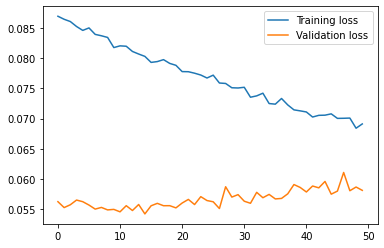

In [331]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(["Training loss", "Validation loss"])

In [332]:
model.evaluate(X_test, y_test)

113/113 [==============================] - 2s 16ms/step - loss: 0.0546 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00


[0.05458918958902359, 0.0, 0.0]

## Audio analysis and onset extraction

In [333]:
test_index = split_idx[-n_test:][0]
audio = tfio.audio.AudioIOTensor('datasets/initslurtest_vn/initslurtest_vn_wav/slurtest{:02d}.wav'.format(test_index))
audio_tensor = tf.squeeze(audio[:], axis=[-1])
audio_tensor = tf.cast(audio_tensor, tf.float32)/np.max(audio_tensor)

In [334]:
with open('datasets/initslurtest_vn/spectrogram/slurtest{:02d}.pickle'.format(test_index), 'rb') as handle:
    spects=pickle.load(handle)


In [335]:
onset_times = genfromtxt('datasets/initslurtest_vn/initslurtest_vn_annotations/{:02d}.txt'.format(test_index), delimiter=',')
times = np.arange(0, len(audio_tensor)/44100, 440/44100)
labels = get_label_vector(times, onset_times, fuzzy=False)

Sum of onehot:  52
Len of onset times:  52


In [336]:
with open('datasets/initslurtest_vn/frames/slurtest{:02d}.pickle'.format(test_index), 'rb') as handle:
    frames=pickle.load(handle)
print(frames.shape)

(4020, 80, 15, 3)


Onsets detected:  51 51


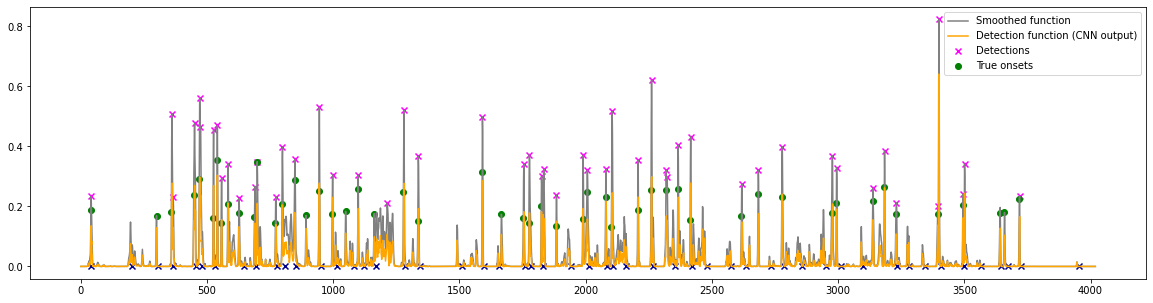

In [338]:
from scipy.signal import find_peaks
from librosa.util import peak_pick

kernel_size = 5
threshold = 0.2
thres2=0.1

pred_onsets = model.predict(frames)[:,0]
plt.figure(figsize=(20,5))

smoothed = np.convolve(pred_onsets, np.hamming(kernel_size), mode='same')
plt.plot(smoothed, c='gray')
plt.plot(pred_onsets, c='orange')

peaks, _ = find_peaks(smoothed, height=threshold)
peaks2 = peak_pick(smoothed, pre_max=5, post_max=1, pre_avg=5, post_avg=1, delta=thres2, wait=10)
print("Onsets detected: ", len(peaks), len(peaks2))
plt.scatter(peaks, smoothed[peaks], c='magenta', marker='x')
plt.scatter(peaks2, smoothed[peaks2], c='green', marker='o')

plt.scatter(onset_times*sr/HOP, np.zeros_like(onset_times), marker='x', c='darkblue')
plt.legend(["Smoothed function", "Detection function (CNN output)", "Detections", "True onsets"])
plt.show()

In [339]:
from analyze_detection import evaluate

true = onset_times
pred = peaks*HOP/sr

[CD,FN,FP,doubles,merged] = evaluate(true, pred, tol_sec=0.25)

print("Precision: {:.1f} %".format( 100*CD/(CD+FP)))
print("Recall: {:.1f} %".format( 100*CD/(CD+FN)))

Precision: 57.9 %
Recall: 63.5 %


In [114]:
#f = open("datasets/initslurtest_vn/model-output/bockmodel-220315-slurtest{:02d}.txt".format(test_index), "w")
#for i in range(len(peaks)):
#    f.write(str(np.round((peaks[i]+7)*440/44100, decimals=2))+ "\n")
#f.close()